# **A computer vision pipeline for Facial Emotion Recognition**

### **Behzad Javaheri**

The task here is to develop a pipeline for facial emotion recognition using provided cropped and aligned faces that are numerically labelled and express a defined emotion.

To implement facial recognition, comparative study of the performance of SVM, MLP and CNN for facial emotion classification will be performed. 

**Importing common libraries**

In [18]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import save
from numpy import load
import os, glob, pickle
import glob
import time
import copy
from random import shuffle
from scipy import stats
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

### If not already installed, the following command will install openCV. Uncomment and run where necessary
!pip install opencv-python==4.4.0.46
import cv2
from tqdm import tqdm
from skimage.feature import hog
from skimage.transform import resize
from itertools import chain
from skimage import io

import matplotlib.pyplot as plt
import IPython.display as ipd 
import plotly.io as pio
import matplotlib as mpl
from matplotlib.colors import Normalize
import seaborn as sns
# to improve matplotlib graphs
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve,accuracy_score 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from joblib import dump, load

#!pip install yellowbrick
#!pip install -U yellowbrick
import yellowbrick as yb
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ClassPredictionError, ROCAUC, ConfusionMatrix
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import LearningCurve, ValidationCurve, CVScores
from yellowbrick.style.rcmod import set_aesthetic, set_palette


def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Assuming that we are on a CUDA machine, this should print a CUDA device:
#print(device)

**Connect to Google Drive**

In [19]:
### Run if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setting the directory path**

In [20]:
import os

### Run if you use colab
# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ComputerVision' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['data', 'labs', 'ComputerVision_v1.ipynb', 'Copy of ComputerVision_v1.ipynb', 'ComputerVision_v2.ipynb', 'ComputerVision_v3.ipynb', 'ComputerVision_v4.ipynb', 'ComputerVision_v5.ipynb']


**Data extraction**

In [4]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

**Creating variables for train and test datasets and labels**

In [5]:
### If you run locall
#train_set = "C:/Users/behza/Desktop/MSc/Teaching/Teaching material/Computer Vision/Coursework/data/train"
#test_set = "C:/Users/behza/Desktop/MSc/Teaching/Teaching material/Computer Vision/Coursework/data/test"
#labels_path = "C:/Users/behza/Desktop/MSc/Teaching/Teaching material/Computer Vision/Coursework/data/labels"

### If you use Colab
train_set = "/content/train"
test_set = "/content/test"
labels_path = "/content/labels"

In [21]:
# Inpired by the lab sessions

train_labels = []
test_labels = []
train_filenames = []
test_filenames = []

emotions={
  '1':'surprise',
  '2':'fear',
  '3':'disgust',
  '4':'happiness',
  '5':'sadness',
  '6':'anger',
  '7':'neutral'}

for file in os.listdir(labels_path):
  if file.startswith("list_label_train"):
    train_fname = file
    with open(labels_path + "/" + train_fname, "r") as label_train:
      lines =label_train.readlines()
      for l in lines:
        as_elems = l.split("\n',")[0].replace("\n","").split(" ")
        train_filenames.append(as_elems[0])
        train_labels.append(emotions[as_elems[1]])
    df_train = pd.DataFrame({"Train file names": train_filenames, "Train emotions": train_labels})

  else:
    test_fname = file
    with open(labels_path + "/" + test_fname, "r") as label_test:
      lines =label_test.readlines()
      for l in lines:
        as_elems = l.split("\n',")[0].replace("\n","").split(" ")
        test_filenames.append(as_elems[0])
        test_labels.append(emotions[as_elems[1]])
    df_test = pd.DataFrame({"Test file names": test_filenames, "Test emotions": test_labels})


**Feature extraction for the training dataset**

In [7]:
#https://github.com/BansiG/Comparative-study-of-ED-SVM-ANN-and-CNN-for-Face-Recognition-using-SIFT-and-HoG-feature-extractors/blob/master/sift_svm.py

sift = cv2.SIFT_create()
orb = cv2.ORB_create(nfeatures=2000)

### Defining y label for training
y_train = df_train["Train emotions"]
### Defining empty containers for data collection
train_pixels_flat = []
train_pixels = []
train_sift = []
y_train_sift = []
y_train_hog_s = []
train_hog_s = []
train_orb = []
y_train_orb = []

### Defining the path to the images
#files = glob.glob("data/train/*.jpg")
##Enable below if using Colab
files = glob.glob("/content/train/*.jpg")
i = 0
for indiv_img in tqdm(range(len(files))):
  image = cv2.imread(files[indiv_img], cv2.IMREAD_COLOR)  # Reading the image
  image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)        # Converting to gray
  train_pixels.append(image2)                             # Appending raw pixels
  train_pixels_flat.append(list(chain(*image2)))          # Flattening pixels to save separately
  kb_sift, des_sift = sift.detectAndCompute(image2, None) # Computing SIFT
  if des_sift is None:                                    # Some SIFT return None, skipping these
    pass
  else:
    train_sift.append(des_sift[0].tolist())               # Appending SIFT
    y_train_sift.append(y_train[indiv_img])               # Appending corresponding labels
  #resized_img = resize(image, (128,64)) 
  fd = hog(image2, orientations=8, pixels_per_cell=(8, 8), # HOG extraction
                  cells_per_block=(2, 2))
  #train_hog.append(f_hog)
  train_hog_s.append(fd)                                   # Appending HOG
  y_train_hog_s.append(y_train[indiv_img])                 # Appending corresponding y labels

  kb_orb, des_orb = orb.detectAndCompute(image2, None)     # Computing ORB
  if des_orb is None:                                      # Omitting ORB for images that return None
    pass
  else:
    train_orb.append(des_orb[0].tolist())                  # Appending ORB
    y_train_orb.append(y_train[indiv_img])                 # Appending corresponding y label
  i + 1

### Getting the extracted features and their corresponding y labels into right shape
train_pixels= np.array(train_pixels)
train_pixels = np.expand_dims(train_pixels, -1)
train_pixels_flat= np.array(train_pixels_flat)
train_sift= np.array(train_sift)
y_train_sift = np.vstack(y_train_sift)
train_hog_s= np.array(train_hog_s)
y_train_hog_s = np.vstack(y_train_hog_s)
train_orb= np.array(train_orb)
y_train_orb = np.vstack(y_train_orb)

### Saving to load later to avoid re-running feature extraction
save("train_pixels.npy", train_pixels)
save("train_pixels_flat.npy", train_pixels_flat)
save("train_sift.npy", train_sift)
save("y_train_sift.npy", y_train_sift)
save("train_hog_s.npy", train_hog_s)
save("y_train_hog_s.npy", y_train_hog_s)
save("train_orb.npy", train_orb)
save("y_train_orb.npy", y_train_orb)

# Printing the shape of the extracted features and corresponding y labels
print()
print("The shape of the extracted pixels for train dataset {}:".format(train_pixels.shape))
print("The shape of the extracted flattened pixels for train dataset {}:".format(train_pixels_flat.shape))
print()
print("The shape of the extracted SIFT for train dataset {}:".format(train_sift.shape))
print("The shape of the corresponding y SIFT for train dataset {}:".format(y_train_sift.shape))
print()
print("The shape of the extracted HOG for train dataset {}:".format(train_hog_s.shape))
print("The shape of the corresponding y HOG for train dataset {}:".format(y_train_hog_s.shape))
print()
print("The shape of the extracted ORB for train dataset {}:".format(train_orb.shape))
print("The shape of the corresponding y ORB for train dataset {}:".format(y_train_orb.shape))


100%|██████████| 12271/12271 [02:28<00:00, 82.77it/s]



The shape of the extracted pixels for train dataset (12271, 100, 100, 1):
The shape of the extracted flattened pixels for train dataset (12271, 10000):

The shape of the extracted SIFT for train dataset (12264, 128):
The shape of the corresponding y SIFT for train dataset (12264, 1):

The shape of the extracted HOG for train dataset (12271, 3872):
The shape of the corresponding y HOG for train dataset (12271, 1):

The shape of the extracted ORB for train dataset (12020, 32):
The shape of the corresponding y ORB for train dataset (12020, 1):


In [8]:

train_pixels.shape

(12271, 100, 100, 1)

**Feature extraction for the testing dataset**

In [9]:
sift = cv2.SIFT_create()
orb = cv2.ORB_create(nfeatures=2000)

### Defining y label for testing
y_test = df_test["Test emotions"]
### Defining empty containers for data collection
test_pixels_flat = []
test_pixels = []
test_sift = []
y_test_sift = []
y_test_hog_s = []
test_hog_s = []
test_orb = []
y_test_orb = []

### Defining the path to the images
#files = glob.glob("data/test/*.jpg")
##Enable below if using Co,ab
files = glob.glob("/content/test/*.jpg")
i = 0
for indiv_img in tqdm(range(len(files))):
  image = cv2.imread(files[indiv_img], cv2.IMREAD_COLOR)  # Reading the image
  image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)        # Converting to gray
  test_pixels.append(image2)                             # Appending raw pixels
  test_pixels_flat.append(list(chain(*image2)))          # Flattening pixels to save separately
  kb_sift, des_sift = sift.detectAndCompute(image2, None) # Computing SIFT
  if des_sift is None:                                    # Some SIFT return None, skipping these
    pass
  else:
    test_sift.append(des_sift[0].tolist())               # Appending SIFT
    y_test_sift.append(y_test[indiv_img])                # Appending corresponding labels
  #resized_img = resize(image, (128,64)) 
  fd = hog(image2, orientations=8, pixels_per_cell=(8, 8), # HOG extraction
                  cells_per_block=(2, 2))
  #test_hog.append(f_hog)
  test_hog_s.append(fd)                                   # Appending HOG
  y_test_hog_s.append(y_test[indiv_img])                  # Appending corresponding y labels

  kb_orb, des_orb = orb.detectAndCompute(image2, None)     # Computing ORB
  if des_orb is None:                                      # Omitting ORB for images that return None
    pass
  else:
    test_orb.append(des_orb[0].tolist())                  # Appending ORB
    y_test_orb.append(y_test[indiv_img])                  # Appending corresponding y label
  i + 1

### Getting the extracted features and their corresponding y labels into right shape
test_pixels= np.array(test_pixels)
test_pixels = np.expand_dims(test_pixels, -1)
test_pixels_flat= np.array(test_pixels_flat)
test_sift= np.array(test_sift)
y_test_sift = np.vstack(y_test_sift)
test_hog_s= np.array(test_hog_s)
y_test_hog_s = np.vstack(y_test_hog_s)
test_orb= np.array(test_orb)
y_test_orb = np.vstack(y_test_orb)

### Saving to load later to avoid re-running feature extraction
save("test_pixels.npy", test_pixels)
save("test_pixels_flat.npy", test_pixels_flat)
save("test_sift.npy", test_sift)
save("y_test_sift.npy", y_test_sift)
save("test_hog_s.npy", test_hog_s)
save("y_test_hog_s.npy", y_test_hog_s)
save("test_orb.npy", test_orb)
save("y_test_orb.npy", y_test_orb)

# Printing the shape of the extracted features and corresponding y labels
print()
print("The shape of the extracted pixels for test dataset {}:".format(test_pixels.shape))
print("The shape of the extracted flattened pixels for test dataset {}:".format(test_pixels_flat.shape))
print()
print("The shape of the extracted SIFT for test dataset {}:".format(test_sift.shape))
print("The shape of the corresponding y SIFT for test dataset {}:".format(y_test_sift.shape))
print()
print("The shape of the extracted HOG for test dataset {}:".format(test_hog_s.shape))
print("The shape of the corresponding y HOG for test dataset {}:".format(y_test_hog_s.shape))
print()
print("The shape of the extracted ORB for test dataset {}:".format(test_orb.shape))
print("The shape of the corresponding y ORB for test dataset {}:".format(y_test_orb.shape))


100%|██████████| 3068/3068 [00:37<00:00, 82.77it/s]



The shape of the extracted pixels for test dataset (3068, 100, 100, 1):
The shape of the extracted flattened pixels for test dataset (3068, 10000):

The shape of the extracted SIFT for test dataset (3068, 128):
The shape of the corresponding y SIFT for test dataset (3068, 1):

The shape of the extracted HOG for test dataset (3068, 3872):
The shape of the corresponding y HOG for test dataset (3068, 1):

The shape of the extracted ORB for test dataset (2999, 32):
The shape of the corresponding y ORB for test dataset (2999, 1):


**Defining features (x) and target label (y) variables for both training and testing datasets**

In [10]:
### Defining X features and y target variable for both training and testing datasets

scaler = StandardScaler()

########################## Training dataset ##################################
# Raw pixels
X_train_pixels= train_pixels
y_train_pixels = pd.get_dummies(df_train['Train emotions']).to_numpy()
#y_train_pixels=LabelEncoder().fit_transform(y_train_pixels) # Encoding y target variable
# Flattenned pixels
X_train_Fpixels= train_pixels_flat
X_train_Fpixels = scaler.fit_transform(X_train_Fpixels)     # Standard scaling X features
y_train_Fpixels = df_train['Train emotions']
y_train_Fpixels=LabelEncoder().fit_transform(y_train_Fpixels)
# SIFT
X_train_sift= train_sift
X_train_sift = scaler.fit_transform(X_train_sift)           # Standard scaling X features
y_train_sift = y_train_sift
y_train_sift=LabelEncoder().fit_transform(y_train_sift)
#HOG
X_train_hog= train_hog_s
X_train_hog = scaler.fit_transform(X_train_hog)             # Standard scaling X features
y_train_hog = y_train_hog_s
y_train_hog=LabelEncoder().fit_transform(y_train_hog)
# ORB
X_train_orb= train_orb
X_train_orb = scaler.fit_transform(X_train_orb)             # Standard scaling X features
y_train_orb = y_train_orb
y_train_orb=LabelEncoder().fit_transform(y_train_orb)

########################## testing dataset ##################################
# Raw pixels
X_test_pixels= test_pixels
#y_test_pixels = df_test['Test emotions']
y_test_pixels = pd.get_dummies(df_test['Test emotions']).to_numpy()
#y_test_pixels=LabelEncoder().fit_transform(y_test_pixels)
# Flattenned pixels
X_test_Fpixels= test_pixels_flat
X_test_Fpixels = scaler.fit_transform(X_test_Fpixels)     # Standard scaling X features
y_test_Fpixels = df_test['Test emotions']
y_test_Fpixels=LabelEncoder().fit_transform(y_test_Fpixels)
# SIFT
X_test_sift= test_sift
X_test_sift = scaler.fit_transform(X_test_sift)     # Standard scaling X features
y_test_sift = y_test_sift
y_test_sift=LabelEncoder().fit_transform(y_test_sift)
#HOG
X_test_hog= test_hog_s
X_test_hog = scaler.fit_transform(X_test_hog)     # Standard scaling X features
y_test_hog = y_test_hog_s
y_test_hog=LabelEncoder().fit_transform(y_test_hog)
# ORB
X_test_orb= test_orb
X_test_orb = scaler.fit_transform(X_test_orb)     # Standard scaling X features
y_test_orb = y_test_orb
y_test_orb=LabelEncoder().fit_transform(y_test_orb)

# Printing the shape of the extracted features and corresponding y labels
# number of samples in training data
print("The number of the X features for the training data:")
print("[+] Number of raw X training featues:", X_train_pixels.shape[0])
print("[+] Number of flattenned X training featues:", X_train_Fpixels.shape[0])
print("[+] Number of SIFT X training featues:", X_train_sift.shape[0])
print("[+] Number of HOG X training featues:", X_train_hog.shape[0])
print("[+] Number of ORB X training featues:", X_train_orb.shape[0])
print()
print("The number of the y target labels for the training data:")
print("[+] Number of raw y training labels:", y_train_pixels.shape[0])
print("[+] Number of flattenned y training labels:", y_train_Fpixels.shape[0])
print("[+] Number of SIFT y training labels:", y_train_sift.shape[0])
print("[+] Number of HOG y training labels:", y_train_hog.shape[0])
print("[+] Number of ORB y training labels:", y_train_orb.shape[0])
print()
print()
# number of samples in testing data
print("The number of the X features for the testing data:")
print("[+] Number of raw X testing featues:", X_test_pixels.shape[0])
print("[+] Number of flattenned X testing featues:", X_test_Fpixels.shape[0])
print("[+] Number of SIFT X testing featues:", X_test_sift.shape[0])
print("[+] Number of HOG X testing featues:", X_test_hog.shape[0])
print("[+] Number of ORB X testing featues:", X_test_orb.shape[0])
print()
print("The number of the y target labels for the testing data:")
print("[+] Number of raw y testing labels:", y_test_pixels.shape[0])
print("[+] Number of flattenned y testing labels:", y_test_Fpixels.shape[0])
print("[+] Number of SIFT y testing labels:", y_test_sift.shape[0])
print("[+] Number of HOG y testing labels:", y_test_hog.shape[0])
print("[+] Number of ORB y testing labels:", y_test_orb.shape[0])
print()

The number of the X features for the training data:
[+] Number of raw X training featues: 12271
[+] Number of flattenned X training featues: 12271
[+] Number of SIFT X training featues: 12264
[+] Number of HOG X training featues: 12271
[+] Number of ORB X training featues: 12020

The number of the y target labels for the training data:
[+] Number of raw y training labels: 12271
[+] Number of flattenned y training labels: 12271
[+] Number of SIFT y training labels: 12264
[+] Number of HOG y training labels: 12271
[+] Number of ORB y training labels: 12020


The number of the X features for the testing data:
[+] Number of raw X testing featues: 3068
[+] Number of flattenned X testing featues: 3068
[+] Number of SIFT X testing featues: 3068
[+] Number of HOG X testing featues: 3068
[+] Number of ORB X testing featues: 2999

The number of the y target labels for the testing data:
[+] Number of raw y testing labels: 3068
[+] Number of flattenned y testing labels: 3068
[+] Number of SIFT y t

In [11]:
y_test_pixels.shape

(3068, 7)

#### Data split to use a subset of data for SVM grid search

In [12]:

# Split the dataset into train and test
#X_train_Fpixels_NU, X_train_Fpixels_CV, y_train_Fpixels_NU, y_train_Fpixels_CV= train_test_split(X_train_Fpixels, y_train_Fpixels, random_state=42, test_size=0.20)
#X_train_sift_NU, X_train_sift_CV, y_train_sift_NU, y_train_sift_CV= train_test_split(X_train_sift, y_train_sift, random_state=42, test_size=0.20)
#X_train_hog_NU, X_train_hog_CV, y_train_hog_NU, y_train_hog_CV= train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.20)
#X_train_orb = load("C:/Users/behza/Desktop/MSc/Teaching/Teaching material/Computer Vision/Coursework/train_orb.npy")
#y_train_orb = load("C:/Users/behza/Desktop/MSc/Teaching/Teaching material/Computer Vision/Coursework/y_train_orb.npy")
X_train_orb_NU, X_train_orb_CV, y_train_orb_NU, y_train_orb_CV= train_test_split(X_train_orb, y_train_orb, random_state=42, test_size=0.20)
X_train_hog_NU, X_train_hog_CV, y_train_hog_NU, y_train_hog_CV= train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.20)
X_train_sift_NU, X_train_sift_CV, y_train_sift_NU, y_train_sift_CV= train_test_split(X_train_sift, y_train_sift, random_state=42, test_size=0.20)
X_train_Fpixels_NU, X_train_Fpixels_CV, y_train_Fpixels_NU, y_train_Fpixels_CV= train_test_split(X_train_Fpixels, y_train_Fpixels, random_state=42, test_size=0.20)


In [ ]:
X_train_orb

array([[-1.10203553,  1.29176234, -0.49572197, ...,  0.20954408,
         0.64232651,  0.62203524],
       [ 0.98886175, -0.60109233, -0.48007543, ...,  0.83843138,
        -0.35148333, -0.78797045],
       [-0.49677579,  0.71503319, -0.51136851, ...,  0.19644226,
        -0.78357457,  0.97453666],
       ...,
       [ 0.57618466, -0.24618208, -0.13585154, ...,  0.79912592,
        -0.84118673, -0.96422116],
       [ 0.25979889,  0.71503319,  0.91246666, ..., -1.54609963,
        -0.07782555,  0.29890894],
       [-0.1116105 ,  0.34533501, -0.43313581, ...,  0.07852589,
         0.46949001, -1.22859722]])

#### SVM classification using ORB

#### SVM hyperparameter tuning for ORB

{'C': 1.109372079242257, 'gamma': 0.4600392474976758, 'kernel': 'linear'}
0.38512837612537515

Time to run the RandomizedSearchCV for SVC is 111.9277 seconds



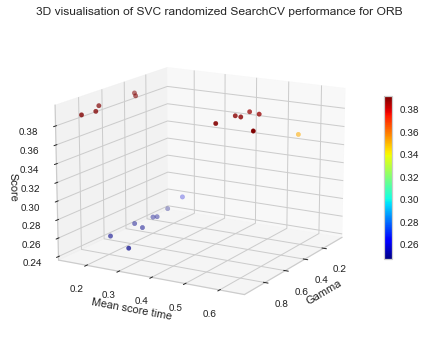

In [ ]:
tic = time.perf_counter()
k = StratifiedKFold(n_splits=5, shuffle=False)
param_grid1 = {'kernel': ['rbf', 'poly', 'linear'],
            "C": stats.uniform(1, 10),
            "gamma": stats.uniform(0.01, 1)}
              
grid1 = RandomizedSearchCV(SVC(), param_distributions = param_grid1, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid1.fit(X_train_orb_CV, y_train_orb_CV)

#print(grid1.cv_results_)
print(grid1.best_params_)
print(grid1.score(X_test_orb, y_test_orb))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid1.best_estimator_, 'SVM_best_estimator_grid1.joblib', compress = 1) # Saving the best estimators
dump(grid1.cv_results_, 'SVM_CV_result_grid1.pkl')                           # Saving the whole object
dump(grid1, 'SVM_whole_object_grid1.pkl')                                    # Saving the whole object

#### Visualisation of the search performance
df_grid1 = load('SVM_CV_result_grid1.pkl')
df_grid1 = pd.DataFrame(df_grid1)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid1['param_gamma']
y_points = df_grid1['mean_score_time']
z_points = df_grid1['mean_test_score']
colour = df_grid1['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Gamma')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of SVC randomized SearchCV performance for ORB", transform=ax.transAxes)
fig.savefig("grid1_3d.svg")


#### SVM classification using ORB with the optimal parameters on the entire training dataset

In [ ]:
tic = time.perf_counter()

model1 = SVC(
    C = 1.109372079242257,
    gamma = 0.4600392474976758,
    kernel = 'linear',
    random_state = 69
)

model1.fit(X_train_orb, y_train_orb)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'SVC Model\'s accuracy on training set is {100*model1.score(X_train_orb, y_train_orb):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model1.score(X_test_orb, y_test_orb):.2f}%')

#f, axes = plt.subplots(2, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    ClassificationReport(model1, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),  
#    ClassPredictionError(model1, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    PrecisionRecallCurve(model1, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),
#    ROCAUC(model1, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_orb, y_train_orb)
#    viz.score(X_test_orb, y_test_orb)
#    viz.finalize()
#f.suptitle('Performance of SVM classifier using ORB for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model1.svg")


Time to fit the model is 78.4729 seconds

SVC Model's accuracy on training set is 38.72%
SVC Model's accuracy on test set is 38.51%


#### SVM classification using SIFT

#### SVM hyperparameter tuning for SIFT

{'C': 1.5242320909013476, 'gamma': 0.6602250924845289, 'kernel': 'rbf'}
0.38657105606258146

Time to run the RandomizedSearchCV for SVC is 3398.9796 seconds



AttributeError: 'Figure' object has no attribute 'colsiftar'

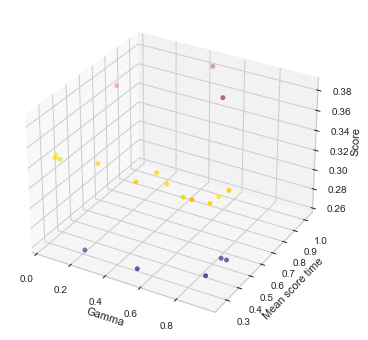

In [ ]:
tic = time.perf_counter()
k = StratifiedKFold(n_splits=5, shuffle=False)
param_grid2 = {'kernel': ['rbf', 'poly', 'linear'],
            "C": stats.uniform(1, 10),
            "gamma": stats.uniform(0.01, 1)}
              
grid2 = RandomizedSearchCV(SVC(), param_distributions = param_grid2, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid2.fit(X_train_sift_CV, y_train_sift_CV)

#print(grid2.cv_results_)
print(grid2.best_params_)
print(grid2.score(X_test_sift, y_test_sift))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid2.best_estimator_, 'SVM_best_estimator_grid2.joblib', compress = 1) # Saving the best estimators
dump(grid2.cv_results_, 'SVM_CV_result_grid2.pkl')                           # Saving the whole object
dump(grid2, 'SVM_whole_object_grid2.pkl')                                    # Saving the whole object

#### Visualisation of the search performance
df_grid2 = load('SVM_CV_result_grid2.pkl')
df_grid2 = pd.DataFrame(df_grid2)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid2['param_gamma']
y_points = df_grid2['mean_score_time']
z_points = df_grid2['mean_test_score']
colour = df_grid2['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Gamma')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of SVC randomized SearchCV performance for SIFT", transform=ax.transAxes)
fig.savefig("grid2_3d.svg")


#### SVM classification using SIFT with the optimal parameters on the entire training dataset

In [ ]:
tic = time.perf_counter()

model2 = SVC(
    C = 1.5242320909013476,
    gamma = 0.6602250924845289,
    kernel = 'rbf',
    random_state = 69
)

model2.fit(X_train_sift, y_train_sift)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'SVC Model\'s accuracy on training set is {100*model2.score(X_train_sift, y_train_sift):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model2.score(X_test_sift, y_test_sift):.2f}%')

#f, axes = plt.subplots(2, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    ClassificationReport(model2, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),  
#    ClassPredictionError(model2, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    PrecisionRecallCurve(model2, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),
#    ROCAUC(model2, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_sift, y_train_sift)
#    viz.score(X_test_sift, y_test_sift)
#    viz.finalize()
#f.suptitle('Performance of SVM classifier using SIFT for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model2.svg")


Time to fit the model is 228.3031 seconds

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 38.69%


#### SVM classification using HOG

{'C': 3.8989668586518524, 'gamma': 0.3452842208549358, 'kernel': 'linear'}
0.6590612777053455

Time to run the RandomizedSearchCV for SVC is 2875.0780 seconds



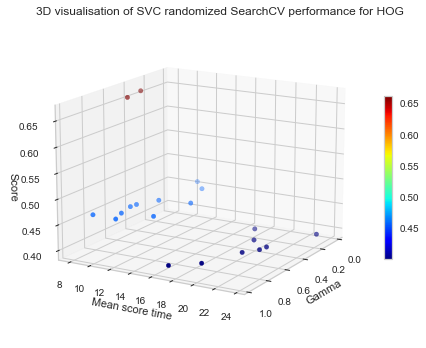

In [ ]:
tic = time.perf_counter()
k = StratifiedKFold(n_splits=5, shuffle=False)
param_grid3 = {'kernel': ['rbf', 'poly', 'linear'],
            "C": stats.uniform(1, 10),
            "gamma": stats.uniform(0.01, 1)}
              
grid3 = RandomizedSearchCV(SVC(), param_distributions = param_grid3, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid3.fit(X_train_hog_CV, y_train_hog_CV)

#print(grid3.cv_results_)
print(grid3.best_params_)
print(grid3.score(X_test_hog, y_test_hog))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid3.best_estimator_, 'SVM_best_estimator_grid3.joblib', compress = 1) # Saving the best estimators
dump(grid3.cv_results_, 'SVM_CV_result_grid3.pkl')                           # Saving the whole object
dump(grid3, 'SVM_whole_object_grid3.pkl')                                    # Saving the whole object

#### Visualisation of the search performance
df_grid3 = load('SVM_CV_result_grid3.pkl')
df_grid3 = pd.DataFrame(df_grid3)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid3['param_gamma']
y_points = df_grid3['mean_score_time']
z_points = df_grid3['mean_test_score']
colour = df_grid3['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Gamma')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of SVC randomized SearchCV performance for HOG", transform=ax.transAxes)
fig.savefig("grid3_3d.svg")

#### SVM classification using HOG with the optimal parameters on the entire training dataset

In [ ]:
tic = time.perf_counter()

model3 = SVC(
    C = 3.8989668586518524,
    gamma = 0.3452842208549358,
    kernel = 'linear',
    random_state = 69
)

model3.fit(X_train_hog, y_train_hog)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'SVC Model\'s accuracy on training set is {100*model3.score(X_train_hog, y_train_hog):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model3.score(X_test_hog, y_test_hog):.2f}%')

#f, axes = plt.subplots(2, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    ClassificationReport(model3, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),  
#    ClassPredictionError(model3, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    PrecisionRecallCurve(model3, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),
#    ROCAUC(model3, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_hog, y_train_hog)
#    viz.score(X_test_hog, y_test_hog)
#    viz.finalize()
#f.suptitle('Performance of SVM classifier using HOG for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model3.svg")


Time to fit the model is 896.3845 seconds

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 66.30%


#### SVM hyperparameter tuning for flattenned pixels

{'C': 8.34870096677655, 'gamma': 0.5818969939016758, 'kernel': 'linear'}
0.5596479791395046

Time to run the RandomizedSearchCV for SVC is 6326.9956 seconds



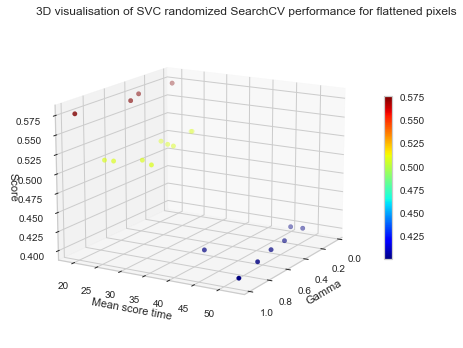

In [ ]:
tic = time.perf_counter()
k = StratifiedKFold(n_splits=5, shuffle=False)
param_grid4 = {'kernel': ['rbf', 'poly', 'linear'],
            "C": stats.uniform(1, 10),
            "gamma": stats.uniform(0.01, 1)}
              
grid4 = RandomizedSearchCV(SVC(), param_distributions = param_grid4, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid4.fit(X_train_Fpixels_CV, y_train_Fpixels_CV)

#print(grid4.cv_results_)
print(grid4.best_params_)
print(grid4.score(X_test_Fpixels, y_test_Fpixels))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid4.best_estimator_, 'SVM_best_estimator_grid4.joblib', compress = 1) # Saving the best estimators
dump(grid4.cv_results_, 'SVM_CV_result_grid4.pkl')                           # Saving the whole object
dump(grid4, 'SVM_whole_object_grid4.pkl')                                    # Saving the whole object

#### Visualisation of the search performance
df_grid4 = load('SVM_CV_result_grid4.pkl')
df_grid4 = pd.DataFrame(df_grid4)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid4['param_gamma']
y_points = df_grid4['mean_score_time']
z_points = df_grid4['mean_test_score']
colour = df_grid4['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Gamma')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of SVC randomized SearchCV performance for flattened pixels", transform=ax.transAxes)
fig.savefig("grid4_3d.svg")

#### SVM classification using flattenned pixels with the optimal parameters on the entire training dataset

In [ ]:
tic = time.perf_counter()

model4 = SVC(
    C = 8.34870096677655,
    gamma = 0.5818969939016758,
    kernel = 'linear',
    random_state = 69
)

model4.fit(X_train_Fpixels, y_train_Fpixels)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'SVC Model\'s accuracy on training set is {100*model4.score(X_train_Fpixels, y_train_Fpixels):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model4.score(X_test_Fpixels, y_test_Fpixels):.2f}%')

#f, axes = plt.subplots(2, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    ClassificationReport(model4, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),  
#    ClassPredictionError(model4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    PrecisionRecallCurve(model4, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),
#    ROCAUC(model4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_Fpixels, y_train_Fpixels)
#    viz.score(X_test_Fpixels, y_test_Fpixels)
#    viz.finalize()
#f.suptitle('Performance of SVM classifier using flattened pixels for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model4.svg")


Time to fit the model is 5183.2758 seconds

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 58.83%


#### MLP hyperparameter tuning for ORB

{'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'epsilon': 1e-08, 'alpha': 0.01, 'activation': 'logistic'}
0.38512837612537515

Time to run the RandomizedSearchCV for SVC is 312.3021 seconds



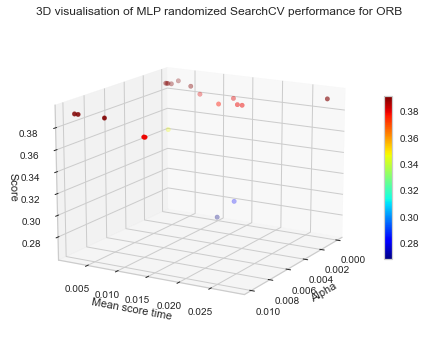

In [ ]:
################################################################################ Do not run ###################################################################
# Initialize the MLP Classifier and choose parameters we want to keep constant
tic = time.perf_counter()

k = StratifiedKFold(n_splits=5, shuffle=False)
mlp = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=42
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
param_grid5 = {
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant'],
}
              
grid5 = RandomizedSearchCV(mlp, param_distributions = param_grid5, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid5.fit(X_train_orb_CV, y_train_orb_CV)

#print(grid6.cv_results_)
print(grid5.best_params_)
print(grid5.score(X_test_orb, y_test_orb))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid5.best_estimator_, 'MLP_best_estimator_grid5.joblib', compress = 1) # Saving the best estimators
dump(grid5.cv_results_, 'MLP_CV_result_grid5.pkl')                           # Saving the whole object
dump(grid5, 'MLP_whole_object_grid5.pkl')                                    # Saving the whole object

### Visualisation of search performance
df_grid5 = load('MLP_CV_result_grid5.pkl')
df_grid5 = pd.DataFrame(df_grid5)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid5['param_alpha']
y_points = df_grid5['mean_score_time']
z_points = df_grid5['mean_test_score']
colour = df_grid5['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of MLP randomized SearchCV performance for ORB", transform=ax.transAxes)
fig.savefig("grid5_3d.svg")

#### MLP classification using ORB with the optimal parameters on the entire training dataset

In [ ]:
# MLP classifer with best parameters from the grid search with the scaled data

tic = time.perf_counter()

model5 = MLPClassifier(
    activation='logistic', 
    solver='sgd', 
    alpha=0.01, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(100, 50), 
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True, # without early stopping
    shuffle = False
)

model5.fit(X_train_orb, y_train_orb)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'MLP Model\'s accuracy on training set is {100*model5.score(X_train_orb, y_train_orb):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model5.score(X_test_orb, y_test_orb):.2f}%')

#f, axes = plt.subplots(3, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    CVScores(model5, cv=5, scoring='f1_weighted', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),
#    LearningCurve(model5, cv=5, scoring='f1_weighted', train_sizes=np.linspace(.1, 1.0, 5), n_jobs=4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    ClassificationReport(model5, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),  
#    ClassPredictionError(model5, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1]),
#    PrecisionRecallCurve(model5, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][0]),
#    ROCAUC(model5, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_orb, y_train_orb)
#    viz.score(X_test_orb, y_test_orb)
#    viz.finalize()
#f.suptitle('Performance of MLP classifier using ORB for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model5.svg")

Time to fit the model is 21.6301 seconds

MLP Model's accuracy on training set is 38.72%
MLP Model's accuracy on test set is 38.51%


#### MLP hyperparameter tuning for SIFT

{'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'epsilon': 1e-08, 'alpha': 0.001, 'activation': 'logistic'}
0.386245110821382

Time to run the RandomizedSearchCV for SVC is 800.6395 seconds



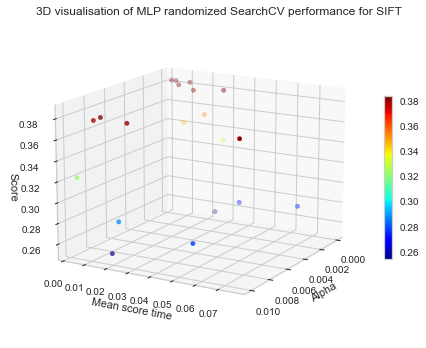

In [ ]:
################################################################################ Do not run ###################################################################
# Initialize the MLP Classifier and choose parameters we want to keep constant
tic = time.perf_counter()

k = StratifiedKFold(n_splits=5, shuffle=False)
mlp = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=42
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
param_grid6 = {
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant'],
}
              
grid6 = RandomizedSearchCV(mlp, param_distributions = param_grid6, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid6.fit(X_train_sift_CV, y_train_sift_CV)

#print(grid6.cv_results_)
print(grid6.best_params_)
print(grid6.score(X_test_sift, y_test_sift))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid6.best_estimator_, 'MLP_best_estimator_grid6.joblib', compress = 1) # Saving the best estimators
dump(grid6.cv_results_, 'MLP_CV_result_grid6.pkl')                           # Saving the whole object
dump(grid6, 'MLP_whole_object_grid6.pkl')                                    # Saving the whole object

### Visualisation of search performance
df_grid6 = load('MLP_CV_result_grid6.pkl')
df_grid6 = pd.DataFrame(df_grid6)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid6['param_alpha']
y_points = df_grid6['mean_score_time']
z_points = df_grid6['mean_test_score']
colour = df_grid6['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of MLP randomized SearchCV performance for SIFT", transform=ax.transAxes)
fig.savefig("grid6_3d.svg")

#### MLP classification using SIFT with the optimal parameters on the entire training dataset

In [ ]:
# MLP classifer with best parameters from the grid search with the scaled data

tic = time.perf_counter()

model6 = MLPClassifier(
    activation='logistic', 
    solver='sgd', 
    alpha=0.001, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(100, 50), 
    learning_rate='constant',
    max_iter=1000,
    early_stopping=True, # without early stopping
    shuffle = False
)

model6.fit(X_train_sift, y_train_sift)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'MLP Model\'s accuracy on training set is {100*model6.score(X_train_sift, y_train_sift):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model6.score(X_test_sift, y_test_sift):.2f}%')

#f, axes = plt.subplots(3, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    CVScores(model6, cv=5, scoring='f1_weighted', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),
#    LearningCurve(model6, cv=5, scoring='f1_weighted', train_sizes=np.linspace(.1, 1.0, 5), n_jobs=4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    ClassificationReport(model6, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),  
#    ClassPredictionError(model6, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1]),
#    PrecisionRecallCurve(model6, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][0]),
#    ROCAUC(model6, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_sift, y_train_sift)
#    viz.score(X_test_sift, y_test_sift)
#    viz.finalize()
#f.suptitle('Performance of MLP classifier using SIFT for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model6.svg")

Time to fit the model is 85.9362 seconds

MLP Model's accuracy on training set is 38.90%
MLP Model's accuracy on test set is 38.62%


#### MLP hyperparameter tuning using HOG

{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (300,), 'epsilon': 0.1, 'alpha': 0.0001, 'activation': 'logistic'}
0.6952411994784876

Time to run the RandomizedSearchCV for SVC is 6587.4757 seconds



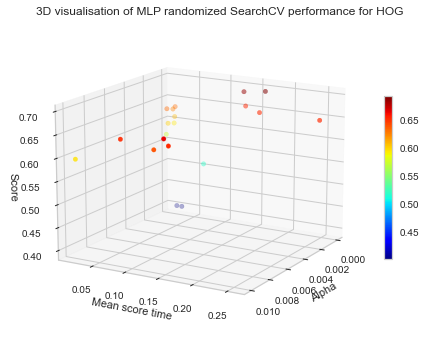

In [ ]:
################################################################################ Do not run ###################################################################
# Initialize the MLP Classifier and choose parameters we want to keep constant
tic = time.perf_counter()

k = StratifiedKFold(n_splits=5, shuffle=False)
mlp = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=42
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
param_grid7 = {
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant'],
}
              
grid7 = RandomizedSearchCV(mlp, param_distributions = param_grid7, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid7.fit(X_train_hog_CV, y_train_hog_CV)

#print(grid7.cv_results_)
print(grid7.best_params_)
print(grid7.score(X_test_hog, y_test_hog))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid7.best_estimator_, 'MLP_best_estimator_grid7.joblib', compress = 1) # Saving the best estimators
dump(grid7.cv_results_, 'MLP_CV_result_grid7.pkl')                           # Saving the whole object
dump(grid7, 'MLP_whole_object_grid7.pkl')                                    # Saving the whole object

### Visualisation of search performance
df_grid7 = load('MLP_CV_result_grid7.pkl')
df_grid7 = pd.DataFrame(df_grid7)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid7['param_alpha']
y_points = df_grid7['mean_score_time']
z_points = df_grid7['mean_test_score']
colour = df_grid7['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of MLP randomized SearchCV performance for HOG", transform=ax.transAxes)
fig.savefig("grid7_3d.svg")

#### MLP classification using HOG with the optimal parameters on the entire training dataset

In [ ]:
# MLP classifer with best parameters from the grid search with the scaled data

tic = time.perf_counter()

model7 = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.0001, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=0.1, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True, # with early stopping
    shuffle = False
)

model7.fit(X_train_hog, y_train_hog)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'MLP Model\'s accuracy on training set is {100*model7.score(X_train_hog, y_train_hog):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model7.score(X_test_hog, y_test_hog):.2f}%')

#f, axes = plt.subplots(2, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    #CVScores(model7, cv=5, scoring='f1_weighted', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),
#    #LearningCurve(model7, cv=5, scoring='f1_weighted', train_sizes=np.linspace(.1, 1.0, 5), n_jobs=4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    ClassificationReport(model7, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),  
#    ClassPredictionError(model7, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    PrecisionRecallCurve(model7, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),
#    ROCAUC(model7, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_hog, y_train_hog)
#    viz.score(X_test_hog, y_test_hog)
#    viz.finalize()
#f.suptitle('Performance of MLP classifier using HOG for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model7.svg")

Time to fit the model is 1208.7202 seconds

MLP Model's accuracy on training set is 79.16%
MLP Model's accuracy on test set is 72.95%


#### MLP hyperparameter tuning using flattened pixels

{'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (180,), 'epsilon': 0.1, 'alpha': 0.01, 'activation': 'logistic'}
0.6264667535853976

Time to run the RandomizedSearchCV for SVC is 17178.8666 seconds



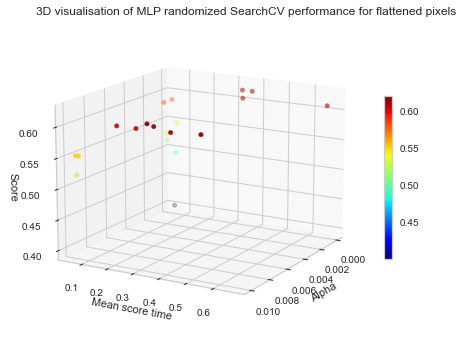

In [ ]:
################################################################################ Do not run ###################################################################
# Initialize the MLP Classifier and choose parameters we want to keep constant
tic = time.perf_counter()

k = StratifiedKFold(n_splits=5, shuffle=False)
mlp = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=42
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
param_grid8 = {
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant'],
}
              
grid8 = RandomizedSearchCV(mlp, param_distributions = param_grid8, n_iter = 20, n_jobs = -1, cv = k, scoring = "accuracy") 
grid8.fit(X_train_Fpixels_CV, y_train_Fpixels_CV)

#print(grid8.cv_results_)
print(grid8.best_params_)
print(grid8.score(X_test_Fpixels, y_test_Fpixels))
print()

toc = time.perf_counter()
print(f"Time to run the RandomizedSearchCV for SVC is {toc - tic:0.4f} seconds")
print()

dump(grid8.best_estimator_, 'MLP_best_estimator_grid8.joblib', compress = 1) # Saving the best estimators
dump(grid8.cv_results_, 'MLP_CV_result_grid8.pkl')                           # Saving the whole object
dump(grid8, 'MLP_whole_object_grid8.pkl')                                    # Saving the whole object

### Visualisation of search performance
df_grid8 = load('MLP_CV_result_grid8.pkl')
df_grid8 = pd.DataFrame(df_grid8)
# Create a 3d scatter plot of the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
x_points = df_grid8['param_alpha']
y_points = df_grid8['mean_score_time']
z_points = df_grid8['mean_test_score']
colour = df_grid8['rank_test_score']
sctt = ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='jet');
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean score time')
ax.set_zlabel('Score')
fig.colorbar(sctt, shrink=0.5)
ax.view_init(elev=15, azim=30)
ax.text2D(0, 1, "3D visualisation of MLP randomized SearchCV performance for flattened pixels", transform=ax.transAxes)
fig.savefig("grid8_3d.svg")

#### MLP classification using flattenned pixels with the optimal parameters on the entire training dataset

In [ ]:
# MLP classifer with best parameters from the grid search with the scaled data

tic = time.perf_counter()

model8 = MLPClassifier(
    activation='logistic', 
    solver='sgd', 
    alpha=0.01, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=0.1, 
    hidden_layer_sizes=(180,), 
    learning_rate='constant',
    max_iter=1000,
    early_stopping=True, # without early stopping
    shuffle = False
)

model8.fit(X_train_Fpixels, y_train_Fpixels)

toc = time.perf_counter()
print(f"Time to fit the model is {toc - tic:0.4f} seconds")
print()

print(f'MLP Model\'s accuracy on training set is {100*model8.score(X_train_Fpixels, y_train_Fpixels):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model8.score(X_test_Fpixels, y_test_Fpixels):.2f}%')

#f, axes = plt.subplots(3, 2,figsize=(25, 12))
#set_aesthetic(palette='paired', font='Arial', font_scale=2, color_codes=True, rc=None)
#visualgrid = [
#    CVScores(model8, cv=5, scoring='f1_weighted', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][0]),
#    LearningCurve(model8, cv=5, scoring='f1_weighted', train_sizes=np.linspace(.1, 1.0, 5), n_jobs=4, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[0][1]),
#    ClassificationReport(model8, support=True, cmap='GnBu', classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][0]),  
#    ClassPredictionError(model8, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[1][1]),
#    PrecisionRecallCurve(model8, per_class=True, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][0]),
#    ROCAUC(model8, classes=['surprise','fear','disgust', 'happiness', 'sadness','anger','neutral'], ax=axes[2][1])
#]

#for viz in visualgrid:
#    viz.fit(X_train_Fpixels, y_train_Fpixels)
#    viz.score(X_test_Fpixels, y_test_Fpixels)
#    viz.finalize()
#f.suptitle('Performance of MLP classifier using flattened pixels for facial emotion recogntion', fontsize=32, weight="bold");
#plt.subplots_adjust(top=0.91)
#viz.show(outpath="model8.svg")

Time to fit the model is 1236.8712 seconds

MLP Model's accuracy on training set is 72.18%
MLP Model's accuracy on test set is 66.13%


#### Pilot study with XGBoost

This did not complete after 2 days running

In [ ]:
#https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
from xgboost import XGBRegressor, plot_importance 

tic = time.perf_counter()

gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': range(60, 220, 40),
    'max_depth': range (2, 10, 1),
    'learning_rate': [0.1, 0.01, 0.05] };

# Instantiate the regressor: gbm
gbm = XGBRegressor();

# Perform grid search: grid_mse
#grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
#                        scoring='neg_mean_squared_error', cv=5, verbose=False);
grid9 = RandomizedSearchCV(gbm, param_distributions = gbm_param_grid, n_iter = 20, n_jobs = -1, cv = 5, scoring = "accuracy") 

grid9.fit(X_train_hog_CV, y_train_hog_CV);

toc = time.perf_counter()
print(f"Time to run the GridSearchCV for XGBoost is {toc - tic:0.4f} seconds")
print()

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid9.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid9.best_score_)))

grid9.best_estimator_ # The best_estimator_ field contains the best model trained by GridSearch.

#### Building Convolutional Neural Network (CNN)

Implementation of this section is inspired by multiple sources.

Computer vision labs

https://github.com/PrudhviGNV/FacialEmotionRecognition-usingCNN/blob/master/Facial_Emotion_Recognition_using_CNN.ipynb

https://github.com/priya-dwivedi/face_and_emotion_detection/blob/master/src/EmotionDetector_v2.ipynb

https://github.com/SanjayMarreddi/Emotion-Investigator/blob/master/Facial%20Expression%20Recognition.ipynb


Close to 100 attempts with different combination of parameters and variation in architecture was tested.

In [22]:
### Importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping


#### Data preparation

In this step we will perform several steps to prepare our data for CNN training.

1. First "to_categorical" is used to convert emotion class vectors to binary class matrix
2. The extracted pixels for training and test datasets are reshaped to have the desired shape
3. Normalisation of data is performed

In [ ]:
X_train_pixels.shape

(12271, 100, 100, 1)

In [23]:
#https://medium.com/@prudhvi.gnv/ultimate-guide-for-facial-emotion-recognition-using-a-cnn-f9239fdc63ad

# Converting to binary class
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_train=y_train_pixels
y_test=y_test_pixels

#label_encoder = LabelEncoder()    # instantiate
#label_encoder.fit(y_train_cnn)        # create the '1'-'7' -> 0-6 transform
#y_train_cnn_encoded = label_encoder.transform(y_train_cnn)    # apply this transformation to y_train labels
#label_encoder.fit(y_test_cnn) 
#y_test_cnn_encoded = label_encoder.transform(y_test_cnn)  # apply the transformation to y_test labels

#y_train_cnn=LabelEncoder().fit_transform(y_train_pixels)
#y_test_cnn=LabelEncoder().fit_transform(y_test_pixels)
#y_train_cnn = to_categorical(y_train_pixels, 7)
#y_test_cnn = to_categorical(y_test_pixels, 7)

# Reshaping pixels
#X_train_pixels_re = X_train_pixels.reshape(12271,100,100,3)
#X_test_pixels_re = X_test_pixels.reshape(3068,100,100,3)

# Data normalisation to help convergence
# Normalisation of the training dataset
#X_train = X_train_pixels.astype('float32')
X_train = X_train_pixels / 255.    #Normalisation to produce range(0,1)
# This step will scale the pixels in the training dataset (range(-1,1))
X_train = X_train - 0.5
X_train = X_train * 2.0

# Normalisation of the testing dataset
#X_test = X_test_pixels.astype('float32')
X_test = X_test_pixels / 255.      #Normalisation to produce range(0,1)
# This step will scale the pixels in the testing dataset (range(-1,1))
X_test = X_test - 0.5
X_test = X_test * 2.0

#### Splitting training dataset further to training and validation

This will allow us to examine overfitting during training. Here, the validation set will be 20% of the entire training dataset.

In [25]:
X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn= train_test_split(X_train, y_train, shuffle=True, random_state=42, test_size=0.20)

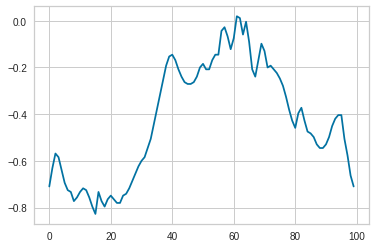

-1.0 1.0


In [ ]:
plt.plot(X_train_cnn[0,0])
plt.show()
type(X_train_cnn)

print(X_train_cnn.min(),X_train_cnn.max()) # we can observe that pixels are scale

#### Testing the shape of training, validation and testing subsets

In [26]:
print("The shape of training dataset: to be used during training")
print('Shape of training dataset: ', X_train_cnn.shape)
print('Shape of training labels: ', y_train_cnn.shape, '\n')
print()
print("The shape of validation dataset: to be used for validation")
print('Shape of validation dataset: ', X_valid_cnn.shape)
print('Shape of validation labels: ', y_valid_cnn.shape, '\n')
print()
print("The shape of testing dataset: to be used only for testing and generalisation and not during training")
print('Shape of testing dataset: ', X_test.shape)
print('Shape of testing labels: ', y_test.shape)

The shape of training dataset: to be used during training
Shape of training dataset:  (9816, 100, 100, 1)
Shape of training labels:  (9816, 7) 


The shape of validation dataset: to be used for validation
Shape of validation dataset:  (2455, 100, 100, 1)
Shape of validation labels:  (2455, 7) 


The shape of testing dataset: to be used only for testing and generalisation and not during training
Shape of testing dataset:  (3068, 100, 100, 1)
Shape of testing labels:  (3068, 7)


#### Building the CNN architecture

#### Defining training parameters

In [27]:
batch_size = 64
num_emotions = 7
num_epochs = 25
input_shape = (100,100, 1)
learning_rate = 0.0005
#epsilon = 1e-7
val_data = (X_valid_cnn, y_valid_cnn)

#### Defining the CNN architecture

CNN is a deep learning algorithm allowing images to be used as input, subsequently assigns importrance to features in the image that could be used to categorise them into different classes. Unlike, SVM and MLP that were implemented earlier, no prior feature extraction is required. The architecture is primarily composed of two layers:

1. The hidden layers in which the feature extraction takes place.
2. The classifier layer

For implementation in this project, Keras with Tensorflow will be employed to build:

1. The convolution layer
2. The pooling layer
3. Batch normalisation
4. The activation layer
5. The dropout layer
6. The flatten layer
7. The dense layer

Additionally, the model will be compiled and a summary of the model provided. Details will include: total, trainable and non-trainable parameters. The size of trainable parameters influences the computation time.

To reduce computation time, a number of different parameter combinations were tested. The parameters that modified include:
1. Batch size
2. Number of episodes
3. Learning rate
4. Filter size

Furthermore, attempt to use GPU was not successful and as such only CPU were utilised for CNN.

In [28]:
# Model Architecture
model = Sequential()

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_emotions, activation='softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print("This is the summary of our CNN model {}".format(model.summary()))
print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0

In [29]:

# Training the CNN model
model.fit(X_train_cnn, y_train_cnn,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data = val_data)

model.save_weights('CNN.h5')

Epoch 1/25
154/154 [==============================] - 19s 16ms/step - loss: 2.2613 - accuracy: 0.2871 - val_loss: 3.7556 - val_accuracy: 0.0652
Epoch 2/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6979 - accuracy: 0.3601 - val_loss: 3.6286 - val_accuracy: 0.2835
Epoch 3/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6949 - accuracy: 0.3731 - val_loss: 3.3625 - val_accuracy: 0.2749
Epoch 4/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6777 - accuracy: 0.3847 - val_loss: 2.6409 - val_accuracy: 0.3886
Epoch 5/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6581 - accuracy: 0.3812 - val_loss: 2.9932 - val_accuracy: 0.3984
Epoch 6/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6643 - accuracy: 0.3843 - val_loss: 2.8413 - val_accuracy: 0.3862
Epoch 7/25
154/154 [==============================] - 2s 13ms/step - loss: 1.6729 - accuracy: 0.3798 - val_loss: 2.9548 - val_accuracy: 0.286

In [ ]:
y_pred = model.predict(X_test)

# Calculating the accuracy of running the model on the testing dataset
true_y=[]
pred_y=[]
yh = y_pred.tolist()
yt = y_test_cnn.tolist()
count = 0
for i in range(len(y_test_cnn)):
    yy = max(yh[i])
    yyt = max(yt[i])
    pred_y.append(yh[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1
        
accuracy = (count/len(y_test_cnn))*100
print("Running the cnn model on the testing dataset results in: %{}".format(round(accuracy)))

Running the cnn model on the testing dataset results in: %38


In [ ]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from keras.preprocessing.image import ImageDataGenerator

data_augmentation = ImageDataGenerator(rotation_range=10, 
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       featurewise_center=False,
                                       featurewise_std_normalization=False,
                                       zoom_range=.1,
                                       horizontal_flip=True)

In [ ]:

model.fit_generator(data_augmentation.flow(X_train_cnn, y_train_cnn, batch_size),
                    epochs=num_epochs, verbose=1,
                    validation_data =val_data)

model.save_weights('CNN_augmented.h5')

Epoch 1/25
154/154 [==============================] - 88s 570ms/step - loss: 1.6438 - accuracy: 0.3859 - val_loss: 1.6557 - val_accuracy: 0.3825
Epoch 2/25
154/154 [==============================] - 87s 566ms/step - loss: 1.6441 - accuracy: 0.3860 - val_loss: 1.6652 - val_accuracy: 0.3821
Epoch 3/25
154/154 [==============================] - 87s 565ms/step - loss: 1.6450 - accuracy: 0.3859 - val_loss: 1.6507 - val_accuracy: 0.3870
Epoch 4/25
154/154 [==============================] - 87s 563ms/step - loss: 1.6441 - accuracy: 0.3860 - val_loss: 1.6522 - val_accuracy: 0.3870
Epoch 5/25
154/154 [==============================] - 87s 563ms/step - loss: 1.6419 - accuracy: 0.3861 - val_loss: 1.8330 - val_accuracy: 0.3499
Epoch 6/25
154/154 [==============================] - 87s 564ms/step - loss: 1.6427 - accuracy: 0.3860 - val_loss: 1.6567 - val_accuracy: 0.3849
Epoch 7/25
154/154 [==============================] - 87s 564ms/step - loss: 1.6430 - accuracy: 0.3860 - val_loss: 1.6500 - val_ac

In [ ]:
y_pred = model.predict(X_test)

# Calculating the accuracy of running the model on the testing dataset
true_y=[]
pred_y=[]
yh = y_pred.tolist()
yt = y_test_cnn.tolist()
count = 0
for i in range(len(y_test_cnn)):
    yy = max(yh[i])
    yyt = max(yt[i])
    pred_y.append(yh[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1
        
accuracy = (count/len(y_test_cnn))*100
print("Running the cnn model on the testing dataset results in: %{}".format(round(accuracy)))